In [ ]:
# 1. Setup and Imports
import os
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from tensorflow import keras

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix

from transformers import (
    BertTokenizer, TFBertForSequenceClassification,
    DistilBertTokenizer, TFDistilBertForSequenceClassification
)

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 2. Load Dataset
if IN_COLAB:
    uploaded = files.upload()
    import io
    df = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
else:
    df = pd.read_csv("youtoxic_english_1000.csv")  # Replace with actual path

df = df.drop(columns=['CommentId', 'VideoId'], errors='ignore')
print("Dataset loaded:", df.shape)
df.head()


Saving youtoxic_english_1000.csv to youtoxic_english_1000 (8).csv
Dataset loaded: (1000, 13)


,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:

# 3. CUDA Check
if torch.cuda.is_available():
    print("CUDA is available. Using GPU for training.")
else:
    print("CUDA is not available. Using CPU for training.")


CUDA is available. Using GPU for training.


In [ ]:

# 4. Label Preprocessing
label_columns = [
    'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene',
    'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist',
    'IsHomophobic', 'IsReligiousHate', 'IsRadicalism'
]
df[label_columns] = df[label_columns].astype(int)
X = df['Text'].values
y = df[label_columns].values



--- Label Distribution ---


/tmp/ipython-input-5-1842250573.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')


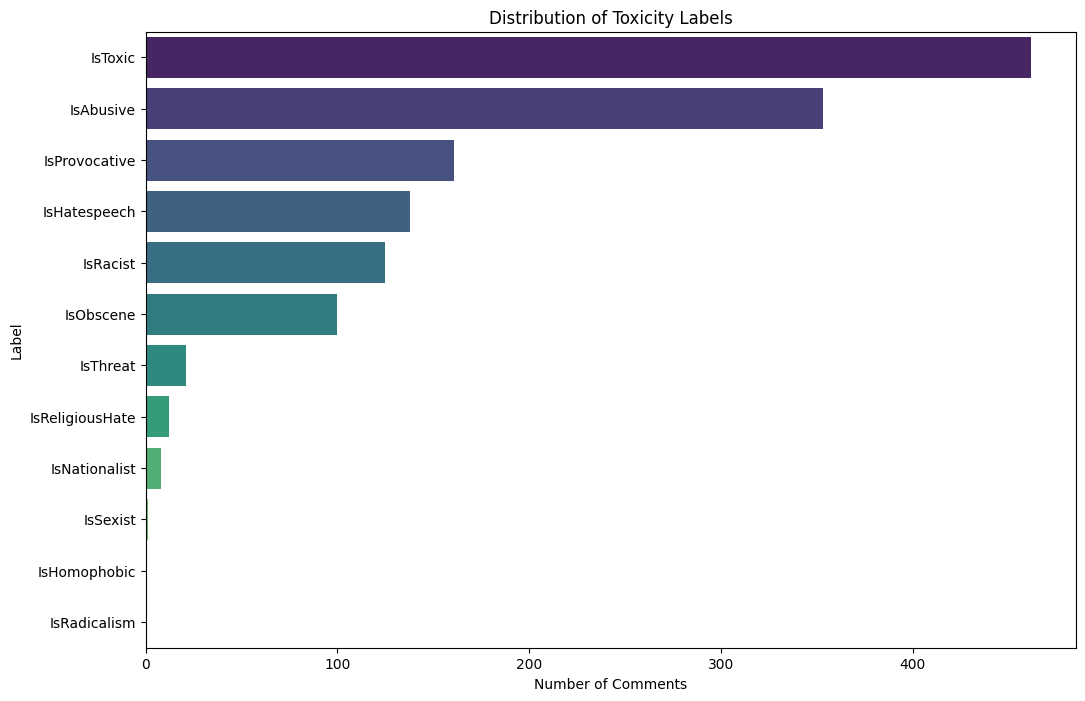

In [ ]:
# --- EDA: Label Distribution ---
print("\n--- Label Distribution ---")
label_counts = df[label_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')
plt.title('Distribution of Toxicity Labels')
plt.xlabel('Number of Comments')
plt.ylabel('Label')
plt.show()

### Point to be noted:
  #### In the above Bar Chart, we can see that the three labels have very few number of comments in the dataset which might cause some challenges in the prediction of the dataset regarding these labels ['IsSexist', 'IsHomophobic', 'IsRaducalism'] during the validation and testing phase.

In [ ]:

# 5. Data Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Model 1: Logistic Regression with TF-IDF
# To understand the performance of our Transformer model, we first build a simpler baseline model.

# Create a pipeline for TF-IDF and Logistic Regression
# We train this on the first label 'IsToxic' for a direct comparison
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Train the baseline model
lr_model = pipeline.fit(X_train, y_train[:, 0])

# Make predictions
baseline_preds = pipeline.predict(X_test)

# Evaluate the baseline model
print("--- Baseline Model (Logistic Regression with TF-IDF) Evaluation ---")
print(classification_report(y_test[:, 0], baseline_preds))
print("Accuracy:", accuracy_score(y_test[:, 0], baseline_preds))
print("-" * 60)

--- Baseline Model (Logistic Regression with TF-IDF) Evaluation ---
              precision    recall  f1-score   support

           0       0.66      0.89      0.76        80
           1       0.79      0.47      0.59        70

    accuracy                           0.69       150
   macro avg       0.72      0.68      0.67       150
weighted avg       0.72      0.69      0.68       150

Accuracy: 0.6933333333333334
------------------------------------------------------------


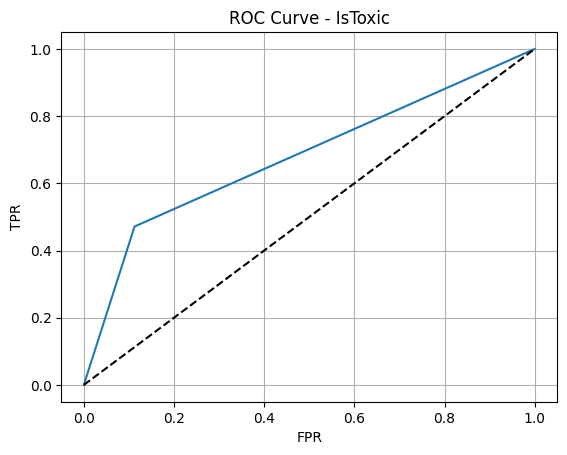

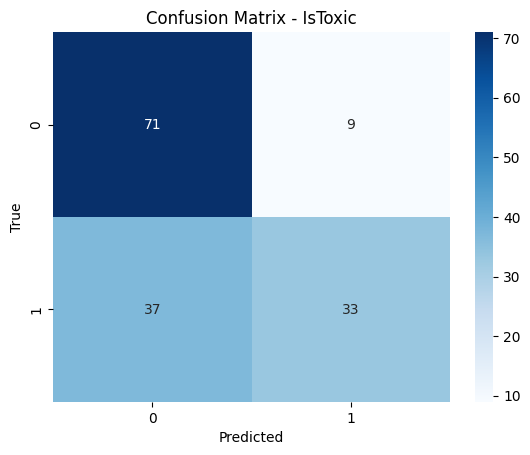

In [ ]:
label_index = label_columns.index('IsToxic')
fpr, tpr, _ = roc_curve(y_test[:, label_index], baseline_preds)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - IsToxic')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()
cm = confusion_matrix(y_test[:, 0], baseline_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - IsToxic")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# 6. Tokenize data for both the model
def tokenize_data(tokenizer, X_data, y_data):
    encodings = tokenizer(list(X_data), truncation=True, padding=True, max_length=128)
    return tf.data.Dataset.from_tensor_slices((dict(encodings), y_data)).batch(16)

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

bert_train = tokenize_data(bert_tokenizer, X_train, y_train)
bert_val = tokenize_data(bert_tokenizer, X_val, y_val)
bert_test = tokenize_data(bert_tokenizer, X_test, y_test)

distil_train = tokenize_data(distilbert_tokenizer, X_train, y_train)
distil_val = tokenize_data(distilbert_tokenizer, X_val, y_val)
distil_test = tokenize_data(distilbert_tokenizer, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def train_model(model, train_ds, val_ds, title):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{title} Loss Curve')
    plt.legend()
    plt.show()
    return model

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
44/44 [==============================] - 73s 618ms/step - loss: 0.4914 - binary_accuracy: 0.8860 - val_loss: 0.3649 - val_binary_accuracy: 0.8506
Epoch 2/20
44/44 [==============================] - 18s 413ms/step - loss: 0.3002 - binary_accuracy: 0.8925 - val_loss: 0.3230 - val_binary_accuracy: 0.8506
Epoch 3/20
44/44 [==============================] - 18s 417ms/step - loss: 0.2669 - binary_accuracy: 0.8925 - val_loss: 0.3004 - val_binary_accuracy: 0.8506
Epoch 4/20
44/44 [==============================] - 18s 421ms/step - loss: 0.2395 - binary_accuracy: 0.9070 - val_loss: 0.2749 - val_binary_accuracy: 0.8800
Epoch 5/20
44/44 [==============================] - 20s 451ms/step - loss: 0.2007 - binary_accuracy: 0.9333 - val_loss: 0.2587 - val_binary_accuracy: 0.9056
Epoch 6/20
44/44 [==============================] - 19s 425ms/step - loss: 0.1900 - binary_accuracy: 0.9345 - val_loss: 0.2571 - val_binary_accuracy: 0.8994
Epoch 7/20
44/44 [==============================] - 19s 42

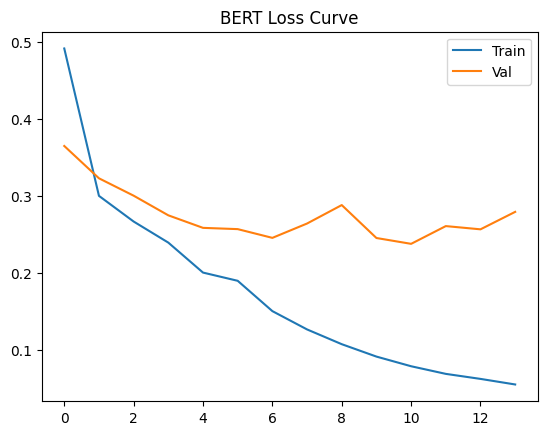

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/20
44/44 [==============================] - 32s 280ms/step - loss: 0.5219 - binary_accuracy: 0.8925 - val_loss: 0.4087 - val_binary_accuracy: 0.8506
Epoch 2/20
44/44 [==============================] - 10s 235ms/step - loss: 0.3328 - binary_accuracy: 0.8925 - val_loss: 0.3387 - val_binary_accuracy: 0.8506
Epoch 3/20
44/44 [==============================] - 10s 226ms/step - loss: 0.2808 - binary_accuracy: 0.8925 - val_loss: 0.3184 - val_binary_accuracy: 0.8506
Epoch 4/20
44/44 [==============================] - 10s 227ms/step - loss: 0.2559 - binary_accuracy: 0.8937 - val_loss: 0.2864 - val_binary_accuracy: 0.8706
Epoch 5/20
44/44 [==============================] - 10s 226ms/step - loss: 0.2173 - binary_accuracy: 0.9210 - val_loss: 0.2677 - val_binary_accuracy: 0.8917
Epoch 6/20
44/44 [==============================] - 10s 222ms/step - loss: 0.1860 - binary_accuracy: 0.9348 - val_loss: 0.2513 - val_binary_accuracy: 0.8994
Epoch 7/20
44/44 [==============================] - 9s 216

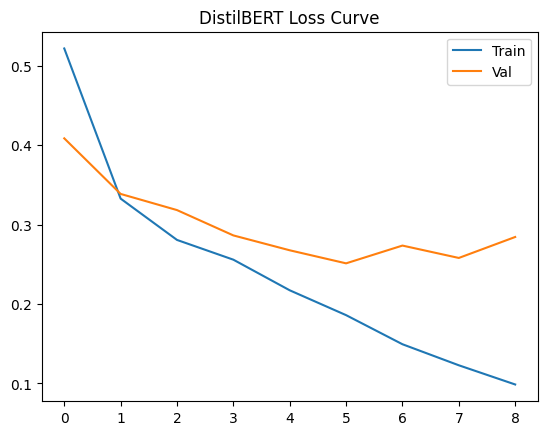

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_columns),
    problem_type='multi_label_classification'
)
bert_model = train_model(bert_model, bert_train, bert_val, "BERT")

distil_model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_columns),
    problem_type='multi_label_classification'
)
distil_model = train_model(distil_model, distil_train, distil_val, "DistilBERT")


10/10 [==============================] - 1s 133ms/step
\nClassification Report (IsToxic):
              precision    recall  f1-score   support

           0       0.81      0.59      0.68        80
           1       0.64      0.84      0.73        70

    accuracy                           0.71       150
   macro avg       0.73      0.72      0.70       150
weighted avg       0.73      0.71      0.70       150



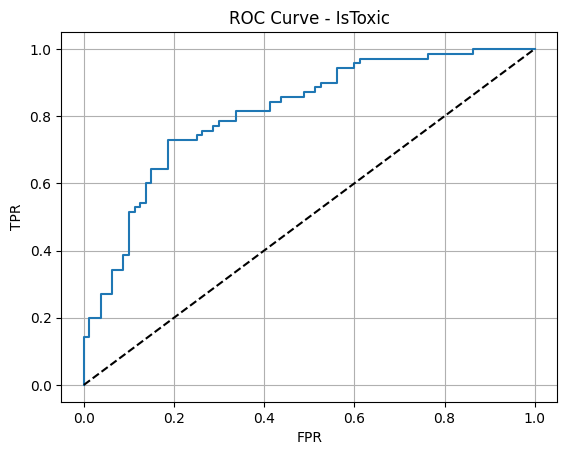

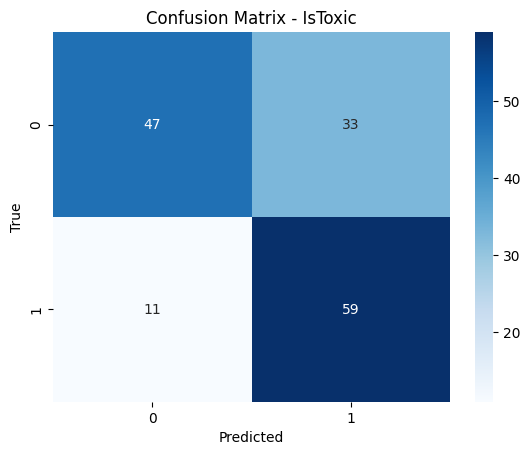

10/10 [==============================] - 1s 65ms/step
\nClassification Report (IsToxic):
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        80
           1       0.67      0.76      0.71        70

    accuracy                           0.71       150
   macro avg       0.72      0.72      0.71       150
weighted avg       0.72      0.71      0.71       150



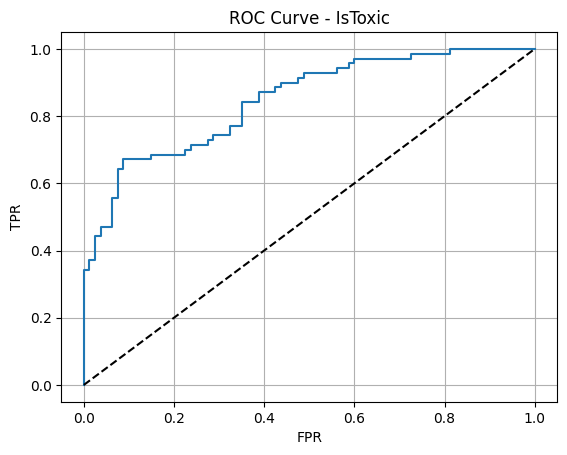

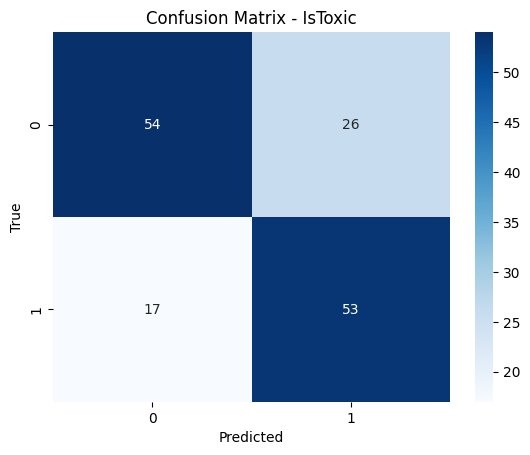

In [ ]:
def evaluate_model(model, test_ds, label_index=label_columns.index('IsToxic')):
    preds = tf.sigmoid(model.predict(test_ds).logits).numpy()
    y_pred = (preds > 0.5).astype(int)
    y_true = y_test[:, label_index]
    y_prob = preds[:, label_index]
    y_bin = y_pred[:, label_index]

    print("\\nClassification Report (IsToxic):")
    print(classification_report(y_true, y_bin))

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve - IsToxic')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.show()

    cm = confusion_matrix(y_true, y_bin)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix - IsToxic")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model(bert_model, bert_test)
evaluate_model(distil_model, distil_test)


In [ ]:
## 7. Comparison and Conclusion

# Compare the accuracy of the baseline model with the BERT model for the 'IsToxic' label.
distil_preds = tf.sigmoid(distil_model.predict(distil_test).logits).numpy()
distil_y_pred = (distil_preds > 0.5).astype(int)

bert_preds = tf.sigmoid(bert_model.predict(bert_test).logits).numpy()
bert_y_pred = (bert_preds > 0.5).astype(int)

bert_accuracy_toxic = accuracy_score(y_test[:, 0], bert_y_pred[:, 0])
baseline_accuracy_toxic = accuracy_score(y_test[:, 0], baseline_preds)
distilbert_accuracy_toxic = accuracy_score(y_test[:, 0], distil_y_pred[:, 0])

print("\n--- Model Comparison for 'IsToxic' label ---")
print(f"Baseline (Logistic Regression) Accuracy: {baseline_accuracy_toxic:.4f}")
print(f"BERT Model Accuracy: {bert_accuracy_toxic:.4f}")
print(f"DistilBERT Model Accuracy: {distilbert_accuracy_toxic:.4f}")

if bert_accuracy_toxic > baseline_accuracy_toxic:
    print("\nThe BERT model outperforms the simpler Logistic Regression model on this task.")
elif baseline_accuracy_toxic > bert_accuracy_toxic:
    print("\nThe Logistic Regression model performs similarly to or better than the BERT model on this task.")
else:
    print("\nThe BERT model performs similarly to or equal to the Logistic Regression model on this task.")

if distilbert_accuracy_toxic > baseline_accuracy_toxic:
    print("\nThe DistilBERT model outperforms the simpler Logistic Regression model on this task.")
elif baseline_accuracy_toxic > distilbert_accuracy_toxic:
    print("\nThe Logistic Regression model performs similarly to or better than the DistilBERT model on this task.")
else:
    print("\nThe DistilBERT model performs similarly to or equal to the Logistic Regression model on this task.")

10/10 [==============================] - 1s 133ms/step

--- Model Comparison for 'IsToxic' label ---
Baseline (Logistic Regression) Accuracy: 0.6933
BERT Model Accuracy: 0.7067
DistilBERT Model Accuracy: 0.7133

The BERT model outperforms the simpler Logistic Regression model on this task.

The DistilBERT model outperforms the simpler Logistic Regression model on this task.


In [ ]:
# 8. Define test examples
test_data = [
    "This was a really helpful and well-made video, thank you!",  # Non-toxic
    "You are an idiot, I can't believe you would say that.",       # Toxic, Abusive
    "I'm going to find you and hurt you.",                         # Toxic, Threat
    "This is the worst music I have ever heard in my life.",      # Non-toxic
    "Go back to your country, you don't belong here.",            # Toxic, Racist, Hatespeech
    "Everyone who believes that is just stupid and should shut up.", # Toxic, Provocative, Abusive
    "I love this channel, always great content! 😊"                # Non-toxic
]
custom_texts = pd.Series(test_data)

In [ ]:
# 8.1 Predict and Display Function for Logistic Regression (TF-IDF)
def predict_with_logreg(pipeline, test_comments, label_name="IsToxic"):
    print(f"\n--- Predictions on Custom Test Data by Logistic Regression (TF-IDF) for '{label_name}' ---")
    preds = pipeline.predict(test_comments)

    for i, text in enumerate(test_comments):
        print(f"\nComment: \"{text}\"")
        if preds[i] == 1:
            print("  Predicted as: Toxic")
        else:
            print("  Predicted as: Non-Toxic")
        print("-" * 40)

# Assuming 'test_data' is your list of custom comments:
test_series = pd.Series(test_data)

# Run the prediction
predict_with_logreg(pipeline, test_series)


--- Predictions on Custom Test Data by Logistic Regression (TF-IDF) for 'IsToxic' ---

Comment: "This was a really helpful and well-made video, thank you!"
  Predicted as: Non-Toxic
----------------------------------------

Comment: "You are an idiot, I can't believe you would say that."
  Predicted as: Toxic
----------------------------------------

Comment: "I'm going to find you and hurt you."
  Predicted as: Non-Toxic
----------------------------------------

Comment: "This is the worst music I have ever heard in my life."
  Predicted as: Non-Toxic
----------------------------------------

Comment: "Go back to your country, you don't belong here."
  Predicted as: Non-Toxic
----------------------------------------

Comment: "Everyone who believes that is just stupid and should shut up."
  Predicted as: Toxic
----------------------------------------

Comment: "I love this channel, always great content! 😊"
  Predicted as: Non-Toxic
----------------------------------------


In [ ]:
# 8.2 Encoding function
def encode_texts(tokenizer, texts):
    return tokenizer(
        list(texts), truncation=True, padding=True, max_length=128, return_tensors='tf'
    )

# Define BATCH_SIZE
BATCH_SIZE = 32

# 8.2.1 Prediction & Display Function
def predict_and_display(model, tokenizer, model_name):
    encodings = encode_texts(tokenizer, custom_texts)
    dataset = tf.data.Dataset.from_tensor_slices(dict(encodings)).batch(BATCH_SIZE)
    logits = model.predict(dataset).logits
    probs = tf.nn.sigmoid(logits).numpy()
    preds = (probs > 0.5).astype(int)

    print(f"\n--- Predictions on Custom Test Data by {model_name} ---")
    for i, text in enumerate(test_data):
        predicted_labels = [label_columns[j] for j in range(len(label_columns)) if preds[i, j] == 1]
        print(f"\nComment: \"{text}\"")
        if predicted_labels:
            print(f"  Predicted as: {', '.join(predicted_labels)}")
        else:
            print("  Predicted as: Non-Toxic")
        print("-" * 40)

# 9 Run predictions for both models
predict_and_display(bert_model, bert_tokenizer, "BERT")
predict_and_display(distil_model, distilbert_tokenizer, "DistilBERT")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


1/1 [==============================] - 5s 5s/step

--- Predictions on Custom Test Data by BERT ---

Comment: "This was a really helpful and well-made video, thank you!"
  Predicted as: Non-Toxic
----------------------------------------

Comment: "You are an idiot, I can't believe you would say that."
  Predicted as: IsToxic, IsAbusive
----------------------------------------

Comment: "I'm going to find you and hurt you."
  Predicted as: IsToxic, IsAbusive
----------------------------------------

Comment: "This is the worst music I have ever heard in my life."
  Predicted as: IsToxic
----------------------------------------

Comment: "Go back to your country, you don't belong here."
  Predicted as: IsToxic, IsAbusive
----------------------------------------

Comment: "Everyone who believes that is just stupid and should shut up."
  Predicted as: IsToxic, IsAbusive
----------------------------------------

Comment: "I love this channel, always great content! 😊"
  Predicted as: Non-Toxi